In [233]:
import pandas as pd
import os
import geopy
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt
import chart_studio.plotly as py
import plotly.graph_objects as go


from tools.dataset_io import DatasetIO

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [118]:
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [30]:
io = DatasetIO()
io.list_available()

['plz_einwohner',
 '01-nypd-arrests',
 '031-kitaliste_aktuell-location',
 '01-nypd-personell',
 '.DS_Store',
 'NYPD_Arrest_Data__Year_to_Date_',
 '01-nypd-shootings',
 '03-kitaliste_aktuell',
 '02-appeals-filed-2017',
 '01-nypd-complaints',
 '04-berliner-toiletten-standorte',
 'moby-bikes-historical-data-012021']

In [404]:
import string
with open('volk.txt', 'rb+') as f:
    lines = f.readlines()

volk_str = lines[0].decode()[:-1]
for line in lines[1:]:
    line = ' '.join(line.decode()[:-1].split())
    numbers = list(line.split(' '))
    if (len(numbers) > 0) and (len(numbers) != 11):
        new_line = ''
        count_n = 0
        while count_n < 11:
            n = numbers[0]
            if n == 't':
                n = 0
            if 0 < int(n) < 24:
                new_char = str(n) + str(numbers[1])
                numbers = numbers[2:]
            else:
                new_char = str(n)
                numbers = numbers[1:]
            new_line += ' ' + new_char
            count_n += 1
        numbers = new_line.strip().split(' ')
    assert len(numbers) == 11, numbers
    assert int(numbers[-1]) < int(numbers[1]), numbers
    volk_str += ' '.join(numbers) + '\n'

with open('volk_corrected.txt', 'wb+') as f:
    f.write(volk_str.encode())

In [481]:
plz_volk = pd.read_csv('volk_corrected.txt', delim_whitespace=True)
plz_volk = plz_volk.applymap(lambda x: 0 if x == 't' else x).astype(int)
plz_volk = plz_volk.groupby('PLZ').sum().reset_index()
plz_volk.columns = ['plz', 'pop', 'pop_under_6', 'pop_6_15', 'pop_15_18', 'pop_18_27', 'pop_27_45', 'pop_45_55', 'pop_55_65', 'pop_65_plus', 'pop_female']
plz_volk

,plz,pop,pop_under_6,pop_6_15,pop_15_18,pop_18_27,pop_27_45,pop_45_55,pop_55_65,pop_65_plus,pop_female
0,10115,26748,1810,2191,499,2463,11270,4345,2403,1767,13172
1,10117,16338,885,924,276,1554,5829,2229,2031,2610,7889
2,10119,19801,1205,1614,453,1656,8021,3578,1917,1357,9736
3,10178,14270,771,811,231,1437,5060,1704,1515,2741,6911
4,10179,26250,1485,1461,363,2967,9104,2947,2837,5086,13011
...,...,...,...,...,...,...,...,...,...,...,...
185,14169,18467,824,1534,556,1599,3349,2561,2732,5312,10057
186,14193,18025,916,1301,427,1394,3730,2515,2549,5193,9539
187,14195,17090,849,1613,588,1633,2953,2614,2356,4484,8936
188,14197,19573,903,1245,404,1633,4208,2673,2974,5533,10509


In [486]:
df_plz = df.groupby('plz').agg({'id': 'count', 'spots': 'sum'}).reset_index()
df_plz.columns = ['plz', 'n_kitas', 'spots']
df_plz = pd.merge(df_plz, plz_volk, on='plz', how='left')

for col in df_plz.columns:
    if col.startswith('pop_'):
        df_plz[f'pct_{col}'] = df_plz[col] / df_plz['pop'] * 100

df_plz

,plz,n_kitas,spots,pop,pop_under_6,pop_6_15,pop_15_18,pop_18_27,pop_27_45,pop_45_55,...,pop_female,pct_pop_under_6,pct_pop_6_15,pct_pop_15_18,pct_pop_18_27,pct_pop_27_45,pct_pop_45_55,pct_pop_55_65,pct_pop_65_plus,pct_pop_female
0,10115,25,1871.0,26748,1810,2191,499,2463,11270,4345,...,13172,6.766861,8.191267,1.865560,9.208165,42.133991,16.244205,8.983849,6.606101,49.244803
1,10117,23,1595.0,16338,885,924,276,1554,5829,2229,...,7889,5.416820,5.655527,1.689313,9.511568,35.677562,13.643041,12.431142,15.975028,48.286204
2,10119,14,1258.0,19801,1205,1614,453,1656,8021,3578,...,9736,6.085551,8.151103,2.287763,8.363214,40.508055,18.069794,9.681329,6.853189,49.169234
3,10178,6,561.0,14270,771,811,231,1437,5060,1704,...,6911,5.402943,5.683252,1.618781,10.070077,35.459005,11.941135,10.616678,19.208129,48.430273
4,10179,10,938.0,26250,1485,1461,363,2967,9104,2947,...,13011,5.657143,5.565714,1.382857,11.302857,34.681905,11.226667,10.807619,19.375238,49.565714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,14169,9,486.0,18467,824,1534,556,1599,3349,2561,...,10057,4.462013,8.306709,3.010776,8.658688,18.135052,13.867981,14.793957,28.764824,54.459306
186,14193,11,793.0,18025,916,1301,427,1394,3730,2515,...,9539,5.081831,7.217753,2.368932,7.733703,20.693481,13.952843,14.141470,28.809986,52.920943
187,14195,14,1226.0,17090,849,1613,588,1633,2953,2614,...,8936,4.967817,9.438268,3.440609,9.555295,17.279111,15.295494,13.785840,26.237566,52.287888
188,14197,11,629.0,19573,903,1245,404,1633,4208,2673,...,10509,4.613498,6.360803,2.064068,8.343126,21.499004,13.656568,15.194400,28.268533,53.691309


In [499]:
# zero kids
df_plz.sort_values(by='pct_pop_under_6').iloc[0]

plz                14053.000000
n_kitas                3.000000
spots                 70.000000
pop                  190.000000
pop_under_6            0.000000
pop_6_15              34.000000
pop_15_18             15.000000
pop_18_27             12.000000
pop_27_45             27.000000
pop_45_55             37.000000
pop_55_65             25.000000
pop_65_plus           40.000000
pop_female           106.000000
pct_pop_under_6        0.000000
pct_pop_6_15          17.894737
pct_pop_15_18          7.894737
pct_pop_18_27          6.315789
pct_pop_27_45         14.210526
pct_pop_45_55         19.473684
pct_pop_55_65         13.157895
pct_pop_65_plus       21.052632
pct_pop_female        55.789474
Name: 175, dtype: float64

Given amount of kitas and spots, estimate percentage of children in the population

<AxesSubplot:xlabel='pct_pop_under_6', ylabel='Density'>

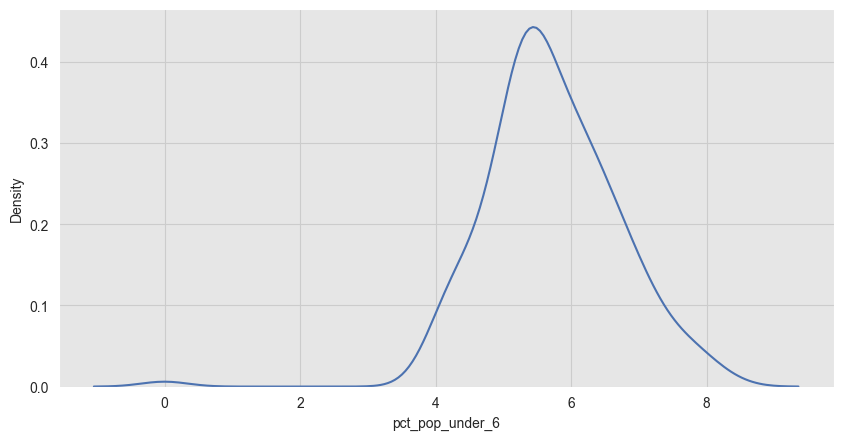

In [506]:
sns.kdeplot(df_plz.pct_pop_under_6)

In [504]:
df_plz.pct_pop_under_6.mean()

5.709837330314495

In [505]:
df_plz.pct_pop_under_6.std()

0.9924097488519534

<AxesSubplot:xlabel='pct_pop_under_6', ylabel='spots'>

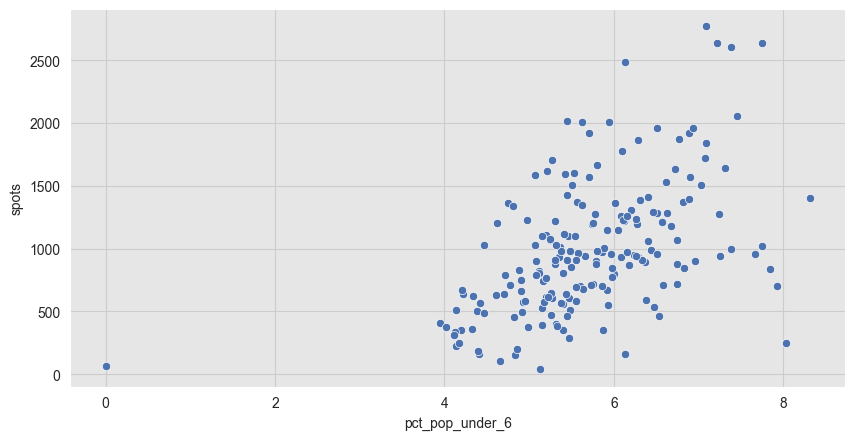

In [501]:
sns.scatterplot(data=df_plz, x='pct_pop_under_6', y='spots')

<AxesSubplot:xlabel='pct_pop_under_6', ylabel='n_kitas'>

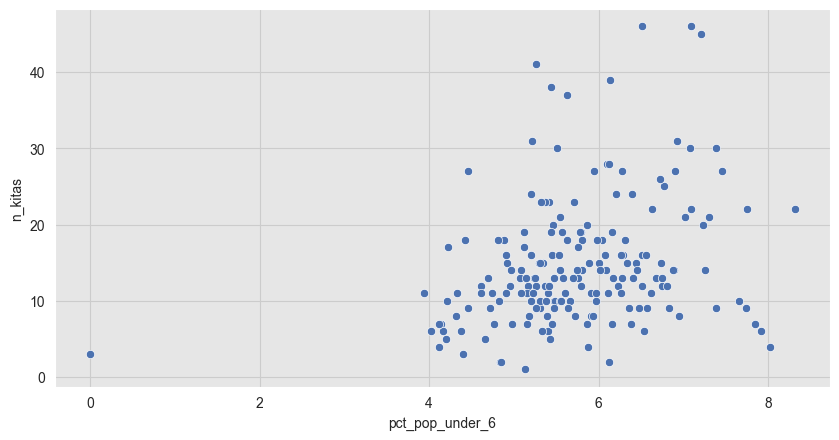

In [503]:
sns.scatterplot(data=df_plz, x='pct_pop_under_6', y='n_kitas')

In [38]:
df_population = io.load_dataset('plz_einwohner')
assert df_population.plz.nunique() == df_population.shape[0]

Loading file "data/plz_einwohner.csv"


In [45]:
df_raw = io.load_dataset('03-kitaliste_aktuell')
df_raw.head()

Loading file "data/03-kitaliste_aktuell.csv"


,Betreuungsbezirk Nr,Betreuungsbezirk,Einrichtungsnummer,Einrichtungsname,Einrichtungsadresse,PLZ,Telefon,Anzahl Plätze,Einrichtungsart,Trägernummer,Trägername,Trägerart
0,1,Mitte,1010010,Kita F.A.I.R.play,Albrechtstr. 020,10117,281 64 73,69.0,Kindertagesstätte,1224,GFJ - gemeinnützige Gesellschaft für Familien-...,Sonstiger freier Träger
1,1,Mitte,1010020,Kita Kinderwelt,An der Kolonnade 003-5,10117,2291378,155.0,Kindertagesstätte,1334,Forum Soziale Dienste GmbH,Sonstiger freier Träger
2,1,Mitte,1010030,FRÖBEL Kindergarten Casa Fantasia,Anklamer Str. 038,10115,030 48495184,69.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger
3,1,Mitte,1010080,Kita Regenbogen,Fehrbelliner Str. 080,10119,449 32 38,91.0,Kindertagesstätte,1202,Pfefferwerk Stadtkultur gGmbH,Sonstiger freier Träger
4,1,Mitte,1010100,"FRÖBEL Kindergarten ""Schatzinsel""",Fischerinsel 008,10179,201 37 88,234.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger


In [48]:
df_raw = pd.merge(df_raw, df_population, how='left', left_on='PLZ', right_on='plz')
assert 'einwohner' in df_raw.columns

In [49]:
df_raw[['Trägernummer', 'Trägername']].drop_duplicates()

,Trägernummer,Trägername
0,1224,GFJ - gemeinnützige Gesellschaft für Familien-...
1,1334,Forum Soziale Dienste GmbH
2,1227,Fröbel Bildung und Erziehung gGmbH
3,1202,Pfefferwerk Stadtkultur gGmbH
5,1318,Kinder im Kiez gGmbH
...,...,...
2746,8362,Evangelische Hoffnungskirche Neu-Tegel
2749,8655,Kita am Südfeld gGmbH
2752,8470,BiZ - Betreuung im Zentrum gGmbH
2773,8976,BIBA Kindertagesstätten gUG


In [50]:
df_raw[['Betreuungsbezirk Nr', 'Betreuungsbezirk']].drop_duplicates()

,Betreuungsbezirk Nr,Betreuungsbezirk
0,1,Mitte
334,2,Friedrichshain-Kreuzberg
623,3,Pankow
1002,4,Charlottenburg-Wilmersdorf
1272,5,Spandau
1414,6,Steglitz-Zehlendorf
1612,7,Tempelhof-Schöneberg
1883,8,Neukölln
2119,9,Treptow-Köpenick
2313,10,Marzahn-Hellersdorf


In [51]:
df_raw.Einrichtungsnummer.nunique()

2777

In [73]:
map_columns_ger_to_eng = {
     'Betreuungsbezirk Nr': 'district_nr',
     'Betreuungsbezirk': 'district',
     'Einrichtungsnummer': 'id',
     'Einrichtungsname': 'name',
     'Einrichtungsadresse': 'address',
     'PLZ': 'postal_code',
     'Telefon': 'phone_number',
     'Anzahl Plätze': 'spots',
     'Einrichtungsart': 'kita_type',
     'Trägernummer': 'carrier_number',
     'Trägername': 'carrier_name',
     'Trägerart': 'carrier_type',
     'einwohner': 'plz_population'
}

map_kita_type = {
    'Kindertagesstätte': 'day_nursery',
    'Eltern-Initiativ-Kindertagesstätte': 'parents_initiative',
    'Eltern-Kind-Gruppe': 'parent_child_group',
    'Waldkindergarten': 'forest_kindergarten'
}

map_carrier_type = {
    'Sonstiger freier Träger': 'other',
    'Betriebskita': 'company_daycare',
    'Eigenbetrieb': 'owner_operated',
    'Diakonisches Werk': 'protestant',
    'EKT': 'parents_initiative',
    'Deutscher Caritasverband': 'caritas',
    'Arbeiterwohlfahrt': 'workers_welfare',
    'private Kita ohne Abschluss der Rahmenvereinbarung': 'private_no_agreement'
}

df = df_raw.copy().rename(columns=map_columns_ger_to_eng)\
    .drop(['district_nr', 'carrier_number', 'phone_number'], axis=1)\
    .assign(
        pct_spots_plz=lambda x: x.groupby('postal_code').spots.apply(lambda gr: gr / gr.sum() * 100),
        pct_spots_district=lambda x: x.groupby('district').spots.apply(lambda gr: gr / gr.sum() * 100)
)
df['kita_type'] = df['kita_type'].map(map_kita_type)
df['carrier_type'] = df['carrier_type'].map(map_carrier_type)
df['postal_code'] = df['postal_code'].astype(str)

df.head()

,district,id,name,address,postal_code,spots,kita_type,carrier_name,carrier_type,plz,plz_population,pct_spots_plz,pct_spots_district
0,Mitte,1010010,Kita F.A.I.R.play,Albrechtstr. 020,10117,69.0,day_nursery,GFJ - gemeinnützige Gesellschaft für Familien-...,other,10117,12217,4.326019,0.326674
1,Mitte,1010020,Kita Kinderwelt,An der Kolonnade 003-5,10117,155.0,day_nursery,Forum Soziale Dienste GmbH,other,10117,12217,9.717868,0.733832
2,Mitte,1010030,FRÖBEL Kindergarten Casa Fantasia,Anklamer Str. 038,10115,69.0,day_nursery,Fröbel Bildung und Erziehung gGmbH,other,10115,20313,3.687867,0.326674
3,Mitte,1010080,Kita Regenbogen,Fehrbelliner Str. 080,10119,91.0,day_nursery,Pfefferwerk Stadtkultur gGmbH,other,10119,16363,7.233704,0.430830
4,Mitte,1010100,"FRÖBEL Kindergarten ""Schatzinsel""",Fischerinsel 008,10179,234.0,day_nursery,Fröbel Bildung und Erziehung gGmbH,other,10179,18664,24.946695,1.107850


## Kita & Carrier type

<AxesSubplot:xlabel='carrier_type', ylabel='district'>

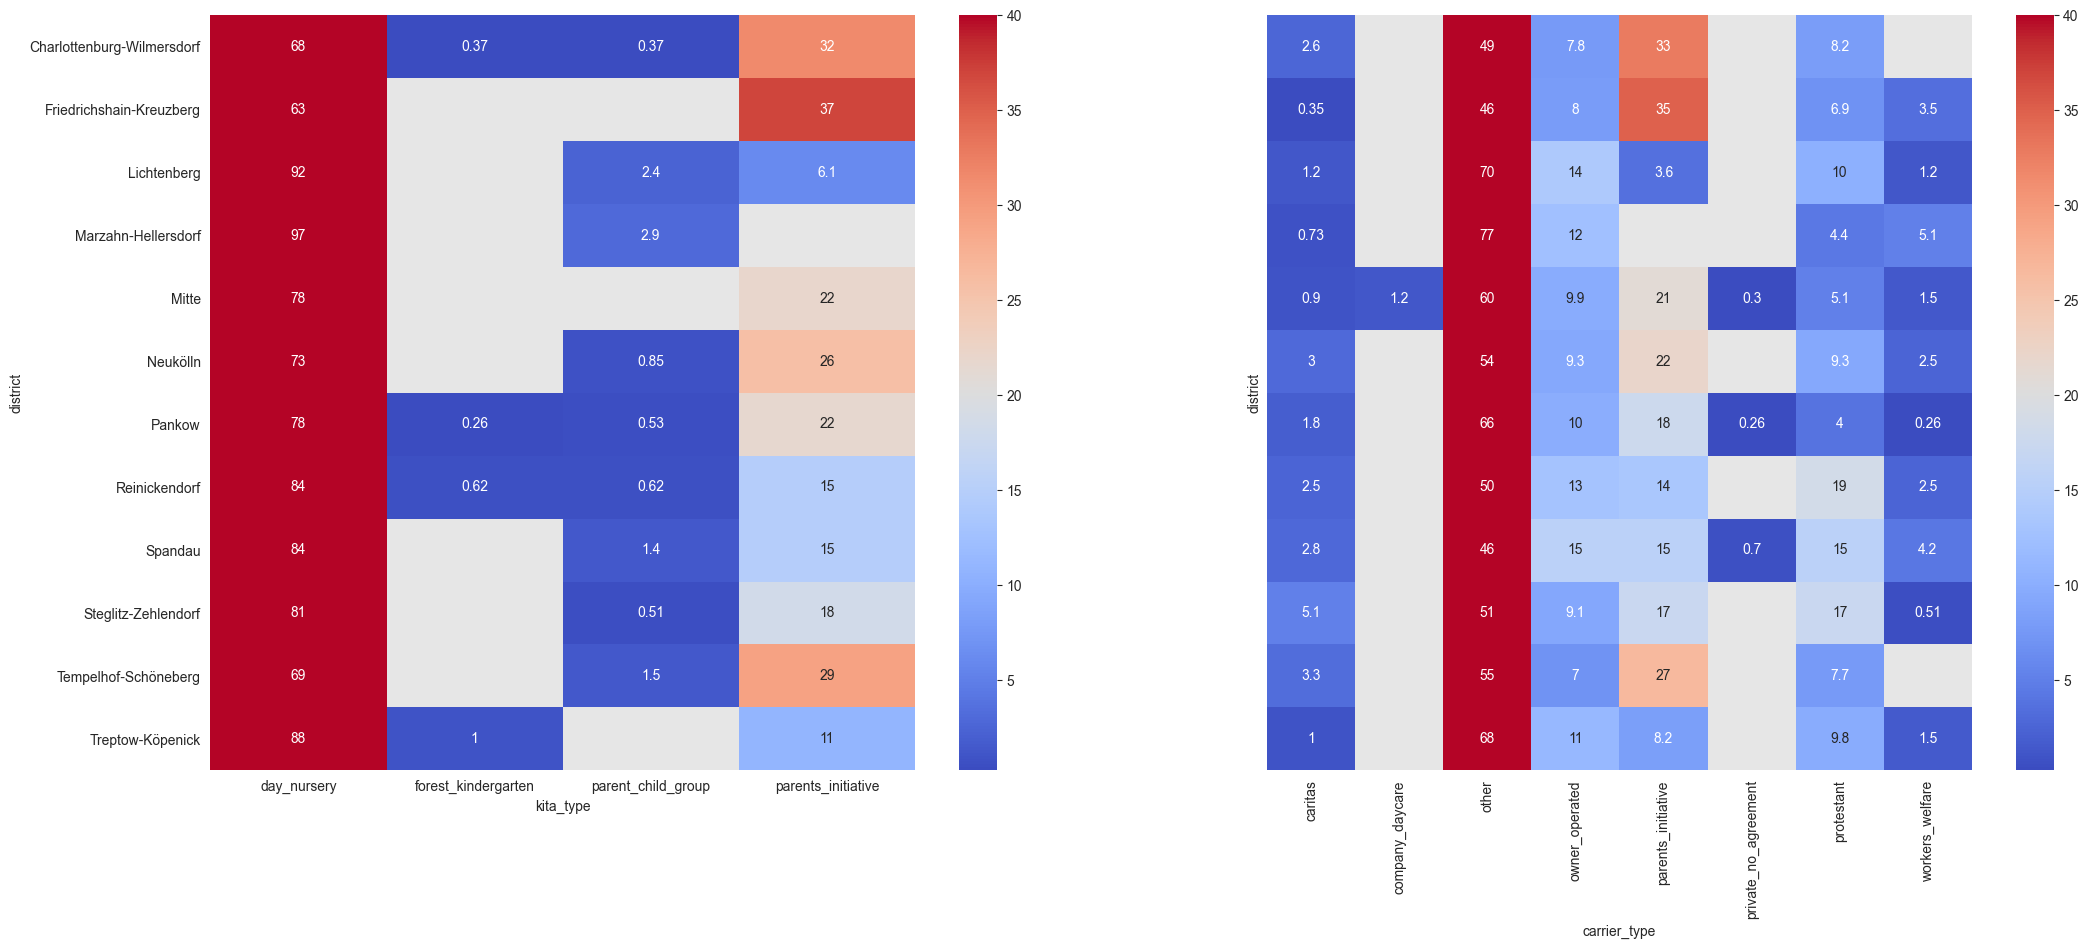

In [207]:
fig, axs = plt.subplots(1,2,figsize=(25,10), sharey=True)

data = df.groupby(['kita_type', 'district']).count().spots.groupby(level=1).apply(lambda x: x/x.sum()*100)
sns.heatmap(data.unstack().T, annot=True, ax=axs[0], cmap='coolwarm', vmax=40)

data = df.groupby(['carrier_type', 'district']).count().spots.groupby(level=1).apply(lambda x: x/x.sum()*100)
sns.heatmap(data.unstack().T, annot=True, ax=axs[1], cmap='coolwarm', vmax=40
           )

In [225]:
df[['kita_type', 'carrier_type']].value_counts()

kita_type            carrier_type        
day_nursery          other                   1476
parents_initiative   parents_initiative       497
day_nursery          owner_operated           279
                     protestant               236
parents_initiative   other                    101
day_nursery          caritas                   57
                     parents_initiative        52
                     workers_welfare           45
parent_child_group   other                     13
                     protestant                 8
day_nursery          company_daycare            4
forest_kindergarten  other                      4
day_nursery          private_no_agreement       3
forest_kindergarten  parents_initiative         1
parents_initiative   protestant                 1
dtype: int64

Day nursery dominates **kita type** in all districts. The next most common type is parents initiative, although it has a significant share only in Charlottenburg, Fhain-Kreuzberg, Tempelhof-Schoneberg and Neukolln. Forest kindergarten and parent child groups are barely present, and not at all in many districts.

The highest amount of protestant carriers is in Reinichedorf, Spandau and Steglitz - places away from the centre and city life.

In [270]:
selector = alt.selection_single(empty='all', fields=['district'])

color_scale = alt.Scale(domain=df.district.unique())

base = alt.Chart(df).properties(
    width=650,
    height=350
).add_selection(selector)

points = base.mark_point(filled=True, size=200).encode(
    x=alt.X('distinct(id):Q'),
    y=alt.Y('sum(plz_population):Q'),
    color=alt.condition(selector,
                        'district:N',
                        alt.value('lightgray'),
                        scale=color_scale),
)

hists = base.mark_bar(opacity=0.5, thickness=100).encode(
    x=alt.X('spots',
            bin=alt.Bin(step=5), # step keeps bin size the same
           ),
    y=alt.Y('count()',
            stack=None),
    color=alt.Color('district:N',
                    scale=color_scale)
).transform_filter(
    selector
)


points | hists

alt.HConcatChart(...)

## Converting address into latitude and longitude

In [115]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Berlin, Germany")

geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [116]:
df['location'] = df['Einrichtungsadresse'].progress_apply(geocode)

  0%|          | 0/2777 [00:00<?, ?it/s]

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Bahnhofstr. 053',), **{}).
Traceback (most recent call last):
  File "/Users/nastjamakhonina/.pyenv/versions/3.9.5/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/nastjamakhonina/.pyenv/versions/3.9.5/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/nastjamakhonina/.pyenv/versions/3.9.5/lib/python3.9/http/client.py", line 1345, in getresponse
    response.begin()
  File "/Users/nastjamakhonina/.pyenv/versions/3.9.5/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/nastjamakhonina/.pyenv/versions/3.9.5/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/User

In [117]:
df['point'] = df['location'].progress_apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

  0%|          | 0/2777 [00:00<?, ?it/s]

In [119]:
df.drop(['point', 'altitude'], axis=1, inplace=True)

In [128]:
df[df.latitude.isnull()]

,Betreuungsbezirk Nr,Betreuungsbezirk,Einrichtungsnummer,Einrichtungsname,Einrichtungsadresse,PLZ,Telefon,Anzahl Plätze,Einrichtungsart,Trägernummer,Trägername,Trägerart,location,latitude,longitude
10,1,Mitte,1010180,Lichtenberger Straße 32/33,Lichtenberger Str. 032-33,10179,2492179,190.0,Kindertagesstätte,120,Kindergärten City,Eigenbetrieb,None,NaN,NaN
12,1,Mitte,1010210,Kita Kleine Auguststr. 10/11Kigä City,Kleine Auguststr. 011-10,10119,2826045,220.0,Kindertagesstätte,120,Kindergärten City,Eigenbetrieb,None,NaN,NaN
13,1,Mitte,1010250,Kita Max-Beer-Str. 24/26/Kigä City,Max-Beer-Str. 024-26,10119,2476849,200.0,Kindertagesstätte,120,Kindergärten City,Eigenbetrieb,None,NaN,NaN
24,1,Mitte,1010550,Kita Oase,Kastanienallee 063A,10119,449 72 89,95.0,Kindertagesstätte,1202,Pfefferwerk Stadtkultur gGmbH,Sonstiger freier Träger,None,NaN,NaN
36,1,Mitte,1010870,Oskar Kirschkern,Anklamer Str. 029(Seitenflügel/Quergebäude),10115,4627116,35.0,Kindertagesstätte,772,Kirschkern e.V.,Sonstiger freier Träger,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,12,Reinickendorf,12202210,Kita Nemo,Kögelstr. 004-5,13403,46897533,105.0,Kindertagesstätte,8310,LebensWelt Kindertagesstätte Amendestraße gGmbH,Sonstiger freier Träger,None,NaN,NaN
2758,12,Reinickendorf,12202230,Die kleinen Grünschnäbel II,Eichborndamm 042- 45,13403,030/ 92288229,55.0,Kindertagesstätte,8459,Die kleinen Grünschnäbel UG (haftungsbeschränkt),Sonstiger freier Träger,None,NaN,NaN
2769,12,Reinickendorf,12202370,GU Senftenberger Ring (FBO),Senftenberger Ring 037-39,13435,015146223616,12.0,Eltern-Kind-Gruppe,7319,Verein für Berliner Stadtmission e. V.,Diakonisches Werk,None,NaN,NaN
2770,12,Reinickendorf,12202380,Sprachfördergruppe Babelfisch (nur Sprachförde...,Nimrodstr. 004-14,13469,NaN,25.0,Kindertagesstätte,1129,Stiftung Pro Gemeinsinn gGmbH,Sonstiger freier Träger,None,NaN,NaN
